In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_json('train.jsonl', lines=True)
test_df = pd.read_json('test.jsonl', lines=True)

In [4]:
value_map = {
    'positive': 1, 
    'negative': -1, 
    'neutral': 0, 
    'unrelated': 2
    }

train_df['annotation'] = train_df['annotation'].str.lower()
test_df['annotation'] = test_df['annotation'].str.lower()

train_df['annotation'] = train_df['annotation'].map(value_map)
test_df['annotation'] = test_df['annotation'].map(value_map)
train_df.head(5)

,text,target_text,annotation
0,Do not stay here. They will rob you upon moveo...,They will rob you blind and send you the bill.,2
1,Love the place. Im disabled so Im always dropp...,Im disabled so Im always dropping batteries an...,2
2,Very friendly staff. Verg accommidating. Cha...,Changed our room to handicappedat the last min.,0
3,Truly one stop shopping. The could use some mo...,"The could use some more handicapped carts, and...",-1
4,It was a very clean and accessible establishment,It was a very clean and accessible establishment,2


<Axes: xlabel='annotation'>

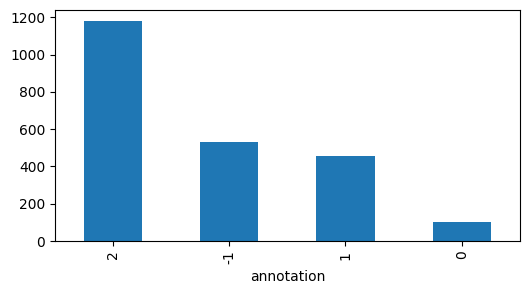

In [5]:
plt.figure(figsize=(6,3))
train_df['annotation'].value_counts().plot(kind='bar')

<Axes: xlabel='annotation'>

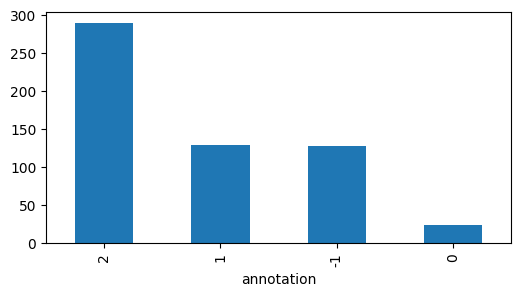

In [13]:
plt.figure(figsize=(6,3))
test_df['annotation'].value_counts().plot(kind='bar')

In [7]:
# Split samples for training set (80%) and testing set (20%)

labels = ['negative', 'neutral', 'positive', 'unrelated']

X_train = train_df['target_text']
y_train = train_df['annotation']

X_test = test_df['target_text']
y_test = test_df['annotation']

### 1. TF-IDF + RF

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=66))
])

# Define the parameters grid
parameters = [{
    'clf__n_estimators': [100, 200, 300, 400],  # Number of trees
    'clf__max_depth': [10, 20, 40, 80, 100, 120],  # Maximum depth of trees
    'clf__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}]

# Perform grid search
rf_cv = GridSearchCV(pipeline, parameters, cv=10)
rf_cv.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = rf_cv.best_params_
best_accuracy = rf_cv.best_score_
print("best parameters are: %s" % best_params)

# Train the final model using the best parameters
rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=best_params['clf__n_estimators'], 
                                   max_depth=best_params['clf__max_depth'], 
                                   min_samples_leaf=best_params['clf__min_samples_leaf'], 
                                   class_weight='balanced', 
                                   random_state=66))
])
rf = rf.fit(X_train, y_train)

# Predict on the training and testing set
y_trad = rf.predict(X_train)
y_pred = rf.predict(X_test)

# Print accuracy and classification report
print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train) * 100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100))
print(classification_report(y_test, y_pred, target_names=labels))

best parameters are: {'clf__max_depth': 80, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 400}
train accuracy: 93.35%
test accuracy: 71.65%
              precision    recall  f1-score   support

    negative       0.56      0.76      0.64       127
     neutral       0.20      0.09      0.12        23
    positive       0.62      0.59      0.60       129
   unrelated       0.89      0.80      0.84       289

    accuracy                           0.72       568
   macro avg       0.57      0.56      0.55       568
weighted avg       0.73      0.72      0.72       568



### 2. TF-IDF + SGD

In [9]:
from sklearn.linear_model import SGDClassifier

# Define the pipeline with SGDClassifier
pipeline = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', class_weight='balanced'))
])

# Define the parameters grid
parameters = [{
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], # Regularization strength
    'clf__max_iter': [500, 800, 1000, 2000, 3000], # Number of iterations
    'clf__penalty': ['l2', 'l1', 'elasticnet'] # Type of regularization
}]

# Perform grid search
sgd_cv = GridSearchCV(pipeline, parameters, cv=10)
sgd_cv.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = sgd_cv.best_params_
best_accuracy = sgd_cv.best_score_
print("best parameters are: %s" % best_params)

# Train the final model using the best parameters
sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', 
                          alpha=best_params['clf__alpha'], 
                          max_iter=best_params['clf__max_iter'], 
                          penalty=best_params['clf__penalty'], 
                          class_weight='balanced'))
])
sgd = sgd.fit(X_train, y_train)

# Predict on the training and testing set
y_trad = sgd.predict(X_train)
y_pred = sgd.predict(X_test)

# Print accuracy and classification report
print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train)*100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test)*100))
print(classification_report(y_test, y_pred, target_names=labels))

best parameters are: {'clf__alpha': 0.001, 'clf__max_iter': 500, 'clf__penalty': 'l2'}
train accuracy: 91.73%
test accuracy: 76.23%
              precision    recall  f1-score   support

    negative       0.66      0.76      0.71       127
     neutral       0.24      0.30      0.27        23
    positive       0.74      0.62      0.68       129
   unrelated       0.88      0.86      0.87       289

    accuracy                           0.76       568
   macro avg       0.63      0.64      0.63       568
weighted avg       0.77      0.76      0.76       568



### 3. TF-IDF + LR

In [10]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline with LogisticRegression
pipeline = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(class_weight='balanced'))
])

# Define the parameters grid
parameters = [{
    'clf__C': [0.1, 0.5, 1, 2, 5, 10, 20],  # Regularization strength
    'clf__max_iter': [10, 20, 50, 100, 200],  # Number of iterations
    'clf__solver': ['sag', 'saga', 'lbfgs', 'newton-cg']  # Different solvers
}]

# Perform grid search
lr_cv = GridSearchCV(pipeline, parameters, cv=10)
lr_cv.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = lr_cv.best_params_
best_accuracy = lr_cv.best_score_
print("Best parameters are: %s" % best_params)

# Train the final model using the best parameters
lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=best_params['clf__C'], 
                               max_iter=best_params['clf__max_iter'], 
                               solver=best_params['clf__solver'], 
                               class_weight='balanced'))
])
lr = lr.fit(X_train, y_train)

# Predict on the training and testing set
y_trad = lr.predict(X_train)
y_pred = lr.predict(X_test)

# Print accuracy and classification report
print("Train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train) * 100))
print("Test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100))
print(classification_report(y_test, y_pred, target_names=labels))

Best parameters are: {'clf__C': 5, 'clf__max_iter': 10, 'clf__solver': 'newton-cg'}
Train accuracy: 97.71%
Test accuracy: 75.35%
              precision    recall  f1-score   support

    negative       0.62      0.78      0.69       127
     neutral       0.29      0.35      0.31        23
    positive       0.72      0.67      0.70       129
   unrelated       0.90      0.81      0.85       289

    accuracy                           0.75       568
   macro avg       0.63      0.65      0.64       568
weighted avg       0.77      0.75      0.76       568

